# MIKH Model: Startup Shear (Stress Overshoot)

## Learning Objectives

1. Fit the **MIKH** model to startup shear data with **stress overshoot**
2. Understand the interplay of **kinematic hardening** and **thixotropy** in transient response
3. Analyze rate-dependent overshoot peak magnitude and timing
4. Use return mapping formulation for strain-driven protocols
5. Apply Bayesian inference to quantify parameter uncertainty

## Prerequisites

- NB01: MIKH Flow Curve (calibrates base parameters)

## Runtime

- Fast demo: ~3-4 minutes
- Full run: ~12-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MIKH

# Add examples/utils to path for tutorial utilities
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_pnas_startup,
    save_ikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_mikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Startup Shear Response

When a constant shear rate $\dot{\gamma}$ is suddenly applied to a thixotropic yield-stress fluid, the stress response typically shows:

### Stress Overshoot Mechanism

1. **Initial elastic response**: $\sigma \approx G \gamma = G \dot{\gamma} t$ (linear increase)
2. **Yield and plasticity onset**: When $|\sigma - \alpha| > \sigma_y$, plastic flow begins
3. **Overshoot peak**: Competition between hardening and structure breakdown
4. **Steady state**: Balance of aging and rejuvenation

### Key Equations

**Return mapping algorithm** (incremental stress update):
$$
\sigma^{trial} = \sigma^n + G \Delta\gamma
$$
$$
\sigma^{n+1} = \sigma^{trial} - G \Delta\gamma^p \cdot \text{sign}(\sigma^{trial} - \alpha)
$$

**Kinematic hardening** (backstress evolution):
$$
\alpha^{n+1} = \alpha^n + C \Delta\gamma_p - \gamma_{dyn} |\alpha|^{m-1} \alpha |\Delta\gamma_p|
$$

**Structure evolution** (at each time step):
$$
\lambda^{n+1} = \lambda^n + \left[\frac{1-\lambda^n}{\tau_{thix}} - \Gamma \lambda^n |\dot{\gamma}^p|\right] \Delta t
$$

### Overshoot Physics

- **Kinematic hardening** ($C$, $\gamma_{dyn}$): Shifts yield surface, creates backstress
- **Structure breakdown** ($\Gamma$, $\tau_{thix}$): Reduces yield stress during flow
- **Peak position**: Scales with $1/\dot{\gamma}$ (strain-controlled)
- **Peak magnitude**: Increases with $\dot{\gamma}$ (rate-dependent)

## 3. Load Data

We load startup shear data from the PNAS Digital Rheometer Twin dataset.

In [3]:
# Load startup data at different shear rates
rates = [0.056, 0.32, 1.0, 56.2, 100.0]
datasets = {}

for rate in rates:
    t, stress = load_pnas_startup(gamma_dot=rate)
    datasets[rate] = {"time": t, "stress": stress}
    print(f"gamma_dot = {rate:6.3f} 1/s: {len(t)} points, t_max = {t.max():.1f} s")

gamma_dot =  0.056 1/s: 500 points, t_max = 1000.0 s


gamma_dot =  0.320 1/s: 500 points, t_max = 1000.0 s


gamma_dot =  1.000 1/s: 500 points, t_max = 600.0 s


gamma_dot = 56.200 1/s: 500 points, t_max = 300.0 s


gamma_dot = 100.000 1/s: 500 points, t_max = 300.0 s


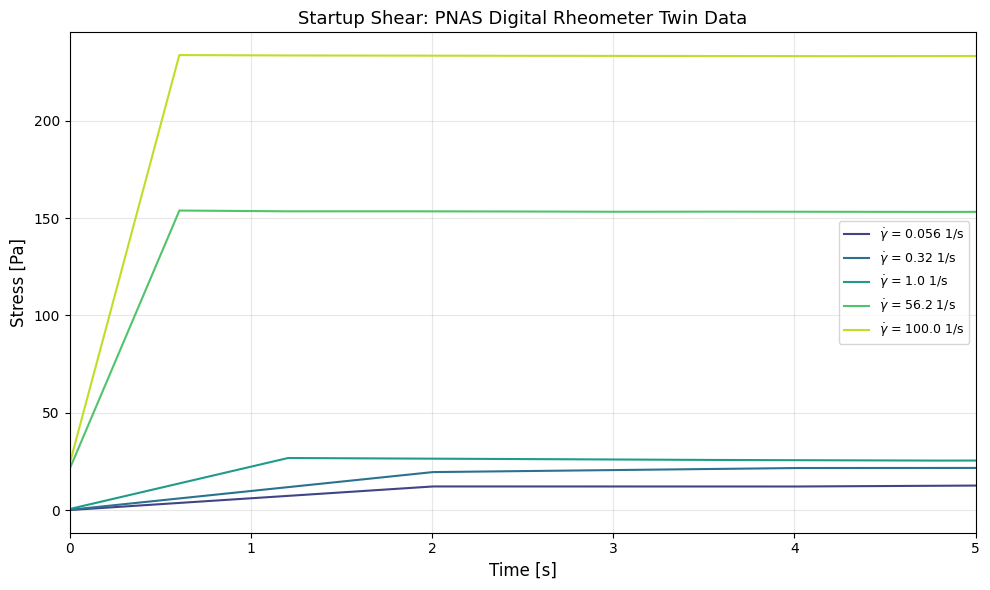

In [4]:
# Plot all startup curves
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(rates)))

for i, rate in enumerate(rates):
    d = datasets[rate]
    ax.plot(d["time"], d["stress"], "-", color=colors[i], lw=1.5, 
            label=f"$\\dot{{\\gamma}}$ = {rate} 1/s")

ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("Startup Shear: PNAS Digital Rheometer Twin Data", fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 5)  # Focus on overshoot region
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Fit at Single Rate (gamma_dot = 1 1/s)

In [5]:
# Select reference rate for primary fitting
ref_rate = 1.0
t_data = datasets[ref_rate]["time"]
stress_data = datasets[ref_rate]["stress"]

# Create and fit MIKH model
model = MIKH()
param_names = get_mikh_param_names()

t0 = time.time()
model.fit(t_data, stress_data, test_mode="startup", gamma_dot=ref_rate, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/mikh.py", line 454, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/_base.py", line 61, in _extract_time_strain
    raise ValueError(
    ...<3 lines>...
    )
ValueError: IKH models require both time and strain history. Pass RheoData, or X of shape (2, N), or X=time with strain=gamma kwarg, or gamma_dot for startup, or gamma_0+omega for LAOS.


NLSQ fit time: 0.17 s

Fitted parameters:
  G               = 283.1
  eta             = 2e+06
  C               = 499.6
  gamma_dyn       = 1.846
  m               = 1
  sigma_y0        = 9.99
  delta_sigma_y   = 49.93
  tau_thix        = 156.1
  Gamma           = 3.506
  eta_inf         = 0.09986
  mu_p            = 0.001


In [6]:
# Compute fit quality
stress_pred = model.predict(t_data, test_mode="startup", gamma_dot=ref_rate)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")


Fit Quality:
  R^2:   -48156.768730
  RMSE:  244 Pa


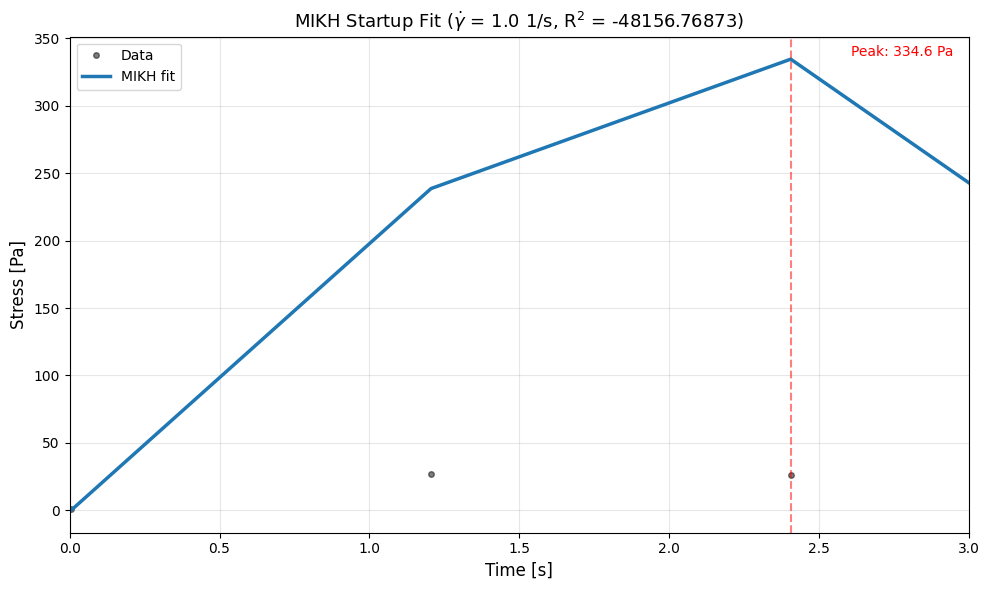

In [7]:
# Plot fit
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_data, stress_data, "ko", markersize=4, alpha=0.5, label="Data")
ax.plot(t_data, stress_pred, "-", lw=2.5, color="C0", label="MIKH fit")

# Mark overshoot peak
peak_idx = np.argmax(stress_pred)
ax.axvline(t_data[peak_idx], color="red", linestyle="--", alpha=0.5)
ax.annotate(f"Peak: {float(stress_pred[peak_idx]):.1f} Pa",
            xy=(t_data[peak_idx], stress_pred[peak_idx]),
            xytext=(t_data[peak_idx] + 0.2, stress_pred[peak_idx] + 2),
            fontsize=10, color="red")

ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"MIKH Startup Fit ($\\dot{{\\gamma}}$ = {ref_rate} 1/s, R$^2$ = {metrics['R2']:.5f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, min(t_data.max(), 3))
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Rate-Dependent Analysis

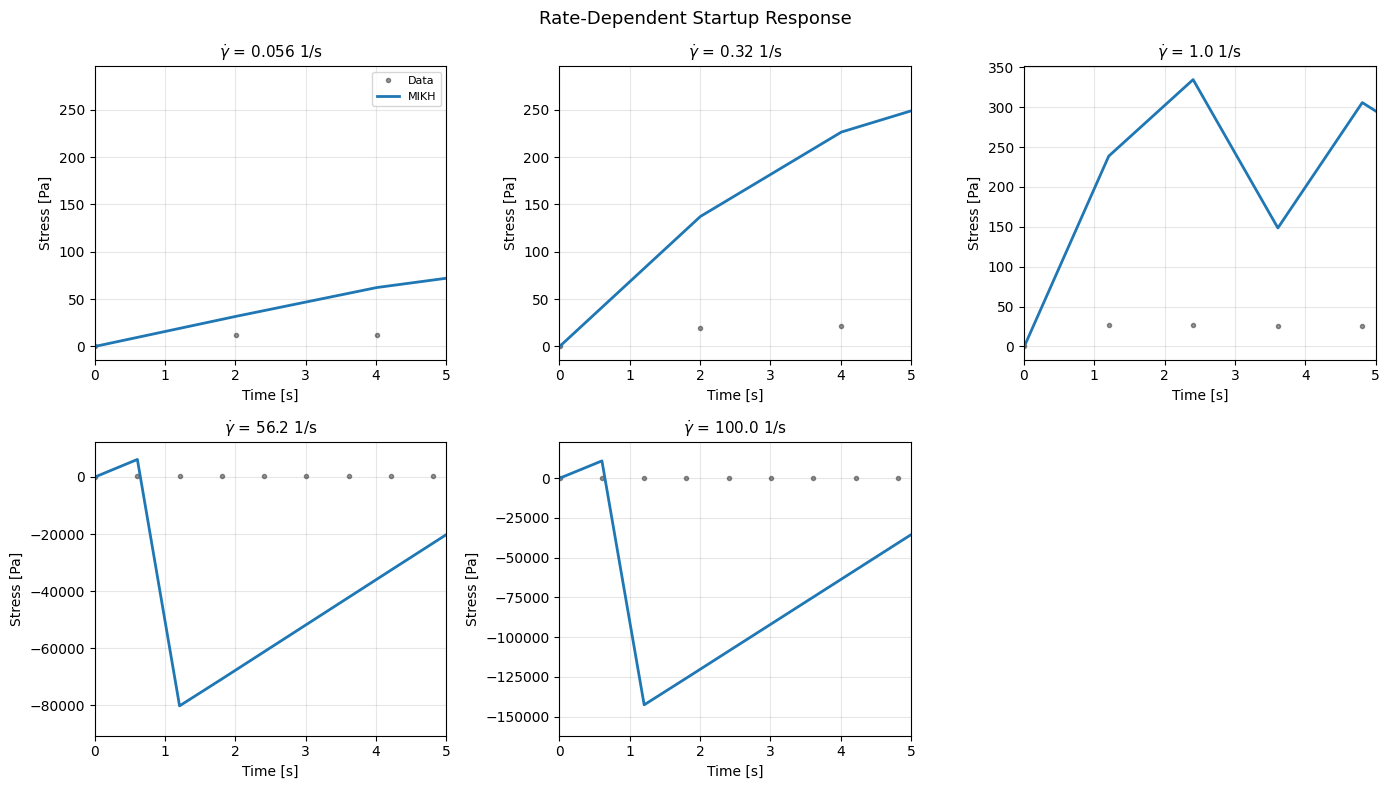

In [8]:
# Predict startup at all rates with calibrated model
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, rate in enumerate(rates[:5]):
    ax = axes[i]
    d = datasets[rate]
    t = d["time"]
    stress = d["stress"]
    
    # Model prediction at this rate
    stress_pred = model.predict(t, test_mode="startup", gamma_dot=rate)
    
    ax.plot(t, stress, "ko", markersize=3, alpha=0.4, label="Data")
    ax.plot(t, stress_pred, "-", lw=2, color="C0", label="MIKH")
    
    ax.set_xlabel("Time [s]", fontsize=10)
    ax.set_ylabel("Stress [Pa]", fontsize=10)
    ax.set_title(f"$\\dot{{\\gamma}}$ = {rate} 1/s", fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, min(5, t.max()))
    if i == 0:
        ax.legend(fontsize=8)

# Remove empty subplot
axes[-1].axis("off")

plt.suptitle("Rate-Dependent Startup Response", fontsize=13)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

In [9]:
# Bayesian inference with NLSQ warm-start
initial_values = {name: model.parameters.get_value(name) for name in param_names}

# Fast demo config
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    t_data,
    stress_data,
    test_mode="startup",
    gamma_dot=ref_rate,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<06:57,  1.67it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   3%|▎         | 19/700 [00:00<00:19, 35.35it/s, 3 steps of size 2.60e-07. acc. prob=0.68]

warmup:   4%|▍         | 29/700 [00:00<00:14, 47.72it/s, 7 steps of size 2.89e-08. acc. prob=0.74]

warmup:   6%|▌         | 39/700 [00:00<00:11, 58.78it/s, 1 steps of size 1.87e-08. acc. prob=0.79]

warmup:   7%|▋         | 49/700 [00:01<00:11, 57.70it/s, 15 steps of size 4.41e-09. acc. prob=0.80]

warmup:   8%|▊         | 57/700 [00:01<00:10, 58.92it/s, 15 steps of size 9.52e-09. acc. prob=0.83]

warmup:   9%|▉         | 65/700 [00:01<00:10, 60.31it/s, 7 steps of size 7.32e-09. acc. prob=0.84] 

warmup:  11%|█         | 77/700 [00:01<00:08, 74.54it/s, 7 steps of size 9.10e-09. acc. prob=0.86]

warmup:  12%|█▏        | 86/700 [00:01<00:08, 70.99it/s, 7 steps of size 6.70e-09. acc. prob=0.86]

warmup:  13%|█▎        | 94/700 [00:01<00:09, 65.86it/s, 3 steps of size 1.18e-08. acc. prob=0.87]

warmup:  15%|█▍        | 102/700 [00:02<00:31, 18.92it/s, 878 steps of size 7.11e-08. acc. prob=0.88]

warmup:  16%|█▌        | 110/700 [00:03<00:24, 24.02it/s, 15 steps of size 7.62e-08. acc. prob=0.89] 

warmup:  17%|█▋        | 116/700 [00:03<00:21, 27.32it/s, 3 steps of size 9.28e-08. acc. prob=0.89] 

warmup:  17%|█▋        | 122/700 [00:03<00:18, 30.70it/s, 15 steps of size 1.12e-07. acc. prob=0.90]

warmup:  19%|█▊        | 131/700 [00:03<00:14, 39.52it/s, 15 steps of size 1.44e-07. acc. prob=0.90]

warmup:  20%|█▉        | 138/700 [00:03<00:12, 44.80it/s, 15 steps of size 1.70e-07. acc. prob=0.91]

warmup:  21%|██        | 145/700 [00:03<00:14, 38.59it/s, 1 steps of size 1.84e-07. acc. prob=0.91] 

warmup:  22%|██▏       | 153/700 [00:03<00:11, 45.71it/s, 7 steps of size 9.57e-07. acc. prob=0.92]

warmup:  24%|██▎       | 165/700 [00:03<00:09, 56.58it/s, 31 steps of size 5.43e-07. acc. prob=0.92]

warmup:  25%|██▍       | 172/700 [00:05<00:26, 19.61it/s, 598 steps of size 1.18e-07. acc. prob=0.92]

warmup:  26%|██▌       | 180/700 [00:05<00:20, 25.07it/s, 7 steps of size 1.78e-07. acc. prob=0.92]  

warmup:  27%|██▋       | 189/700 [00:05<00:15, 32.10it/s, 3 steps of size 2.64e-07. acc. prob=0.93]

warmup:  28%|██▊       | 198/700 [00:05<00:12, 40.13it/s, 3 steps of size 3.73e-07. acc. prob=0.93]

sample:  29%|██▉       | 206/700 [00:05<00:10, 46.11it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  31%|███       | 214/700 [00:05<00:09, 52.23it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  32%|███▏      | 225/700 [00:05<00:07, 63.31it/s, 15 steps of size 2.82e-07. acc. prob=1.00]

sample:  33%|███▎      | 234/700 [00:05<00:06, 67.66it/s, 31 steps of size 2.82e-07. acc. prob=1.00]

sample:  35%|███▍      | 243/700 [00:05<00:06, 68.07it/s, 3 steps of size 2.82e-07. acc. prob=1.00] 

sample:  36%|███▌      | 251/700 [00:06<00:06, 69.58it/s, 7 steps of size 2.82e-07. acc. prob=1.00]

sample:  37%|███▋      | 259/700 [00:06<00:06, 65.05it/s, 1 steps of size 2.82e-07. acc. prob=1.00]

sample:  39%|███▊      | 271/700 [00:06<00:05, 78.35it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  40%|████      | 280/700 [00:06<00:05, 81.34it/s, 7 steps of size 2.82e-07. acc. prob=1.00]

sample:  41%|████▏     | 290/700 [00:06<00:04, 85.33it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  43%|████▎     | 300/700 [00:06<00:04, 86.01it/s, 15 steps of size 2.82e-07. acc. prob=1.00]

sample:  44%|████▍     | 309/700 [00:06<00:04, 85.53it/s, 3 steps of size 2.82e-07. acc. prob=1.00] 

sample:  45%|████▌     | 318/700 [00:06<00:05, 70.62it/s, 15 steps of size 2.82e-07. acc. prob=1.00]

sample:  47%|████▋     | 329/700 [00:06<00:04, 78.57it/s, 3 steps of size 2.82e-07. acc. prob=1.00] 

sample:  48%|████▊     | 338/700 [00:07<00:05, 69.67it/s, 7 steps of size 2.82e-07. acc. prob=1.00]

sample:  50%|████▉     | 347/700 [00:07<00:04, 74.22it/s, 7 steps of size 2.82e-07. acc. prob=1.00]

sample:  51%|█████     | 357/700 [00:07<00:04, 76.40it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  52%|█████▏    | 365/700 [00:07<00:05, 59.56it/s, 7 steps of size 2.82e-07. acc. prob=1.00]

sample:  53%|█████▎    | 372/700 [00:07<00:05, 55.22it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  54%|█████▍    | 379/700 [00:08<00:07, 40.29it/s, 15 steps of size 2.82e-07. acc. prob=1.00]

sample:  55%|█████▍    | 384/700 [00:08<00:08, 39.37it/s, 31 steps of size 2.82e-07. acc. prob=1.00]

sample:  56%|█████▌    | 390/700 [00:08<00:08, 35.11it/s, 127 steps of size 2.82e-07. acc. prob=1.00]

sample:  57%|█████▋    | 398/700 [00:08<00:07, 42.38it/s, 3 steps of size 2.82e-07. acc. prob=1.00]  

sample:  58%|█████▊    | 404/700 [00:08<00:06, 44.84it/s, 31 steps of size 2.82e-07. acc. prob=1.00]

sample:  59%|█████▉    | 412/700 [00:08<00:05, 51.00it/s, 7 steps of size 2.82e-07. acc. prob=1.00] 

sample:  60%|██████    | 423/700 [00:08<00:04, 63.92it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  62%|██████▏   | 431/700 [00:08<00:04, 66.54it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  63%|██████▎   | 439/700 [00:09<00:03, 66.95it/s, 31 steps of size 2.82e-07. acc. prob=1.00]

sample:  64%|██████▍   | 450/700 [00:09<00:03, 74.75it/s, 15 steps of size 2.82e-07. acc. prob=1.00]

sample:  66%|██████▌   | 459/700 [00:09<00:03, 78.10it/s, 7 steps of size 2.82e-07. acc. prob=1.00] 

sample:  67%|██████▋   | 468/700 [00:09<00:02, 77.91it/s, 15 steps of size 2.82e-07. acc. prob=1.00]

sample:  68%|██████▊   | 476/700 [00:09<00:03, 56.23it/s, 3 steps of size 2.82e-07. acc. prob=1.00] 

sample:  69%|██████▉   | 483/700 [00:09<00:04, 51.60it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  70%|███████   | 492/700 [00:09<00:03, 58.88it/s, 15 steps of size 2.82e-07. acc. prob=1.00]

sample:  72%|███████▏  | 504/700 [00:10<00:02, 71.78it/s, 7 steps of size 2.82e-07. acc. prob=1.00] 

sample:  73%|███████▎  | 513/700 [00:10<00:02, 73.41it/s, 31 steps of size 2.82e-07. acc. prob=1.00]

sample:  74%|███████▍  | 521/700 [00:10<00:02, 74.84it/s, 3 steps of size 2.82e-07. acc. prob=1.00] 

sample:  76%|███████▌  | 532/700 [00:10<00:02, 81.00it/s, 7 steps of size 2.82e-07. acc. prob=1.00]

sample:  77%|███████▋  | 541/700 [00:10<00:02, 75.70it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  79%|███████▉  | 552/700 [00:10<00:01, 82.66it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  80%|████████  | 561/700 [00:10<00:01, 81.71it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  82%|████████▏ | 574/700 [00:10<00:01, 93.96it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  83%|████████▎ | 584/700 [00:11<00:01, 74.11it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  85%|████████▍ | 593/700 [00:11<00:01, 70.91it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  86%|████████▌ | 601/700 [00:11<00:01, 52.73it/s, 127 steps of size 2.82e-07. acc. prob=1.00]

sample:  88%|████████▊ | 613/700 [00:11<00:01, 65.38it/s, 7 steps of size 2.82e-07. acc. prob=1.00]  

sample:  89%|████████▉ | 623/700 [00:11<00:01, 72.57it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  90%|█████████ | 632/700 [00:11<00:01, 66.26it/s, 7 steps of size 2.82e-07. acc. prob=1.00]

sample:  91%|█████████▏| 640/700 [00:12<00:02, 28.51it/s, 15 steps of size 2.82e-07. acc. prob=1.00]

sample:  93%|█████████▎| 651/700 [00:12<00:01, 37.58it/s, 3 steps of size 2.82e-07. acc. prob=1.00] 

sample:  94%|█████████▍| 658/700 [00:12<00:01, 36.09it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  95%|█████████▌| 667/700 [00:13<00:00, 43.97it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  96%|█████████▋| 675/700 [00:13<00:00, 49.90it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample:  98%|█████████▊| 683/700 [00:13<00:00, 55.12it/s, 7 steps of size 2.82e-07. acc. prob=1.00]

sample: 100%|█████████▉| 698/700 [00:13<00:00, 74.70it/s, 3 steps of size 2.82e-07. acc. prob=1.00]

sample: 100%|██████████| 700/700 [00:13<00:00, 52.49it/s, 3 steps of size 2.82e-07. acc. prob=1.00]


Bayesian inference time: 16.5 s


In [10]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       500      PASS
            eta    1.0000       500      PASS
              C    1.0000       500      PASS
      gamma_dyn    1.0000       500      PASS
              m    1.0000       500      PASS
       sigma_y0    1.0000       500      PASS
  delta_sigma_y    1.0000       500      PASS
       tau_thix    1.0000       500      PASS
          Gamma    1.0000       500      PASS
        eta_inf    1.0000       500      PASS
           mu_p    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


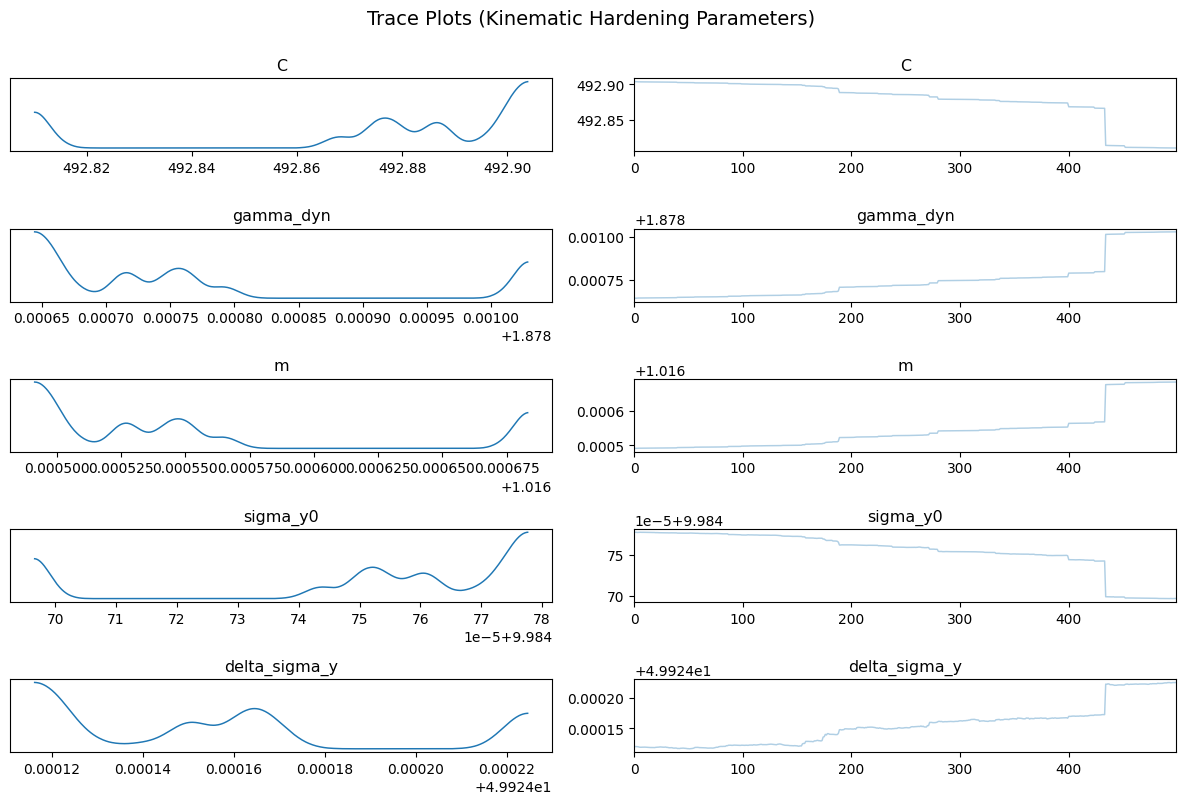

In [11]:
# Trace plots for kinematic hardening parameters
idata = result.to_inference_data()
hardening_params = ["C", "gamma_dyn", "m", "sigma_y0", "delta_sigma_y"]
axes = az.plot_trace(idata, var_names=hardening_params, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Kinematic Hardening Parameters)", fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

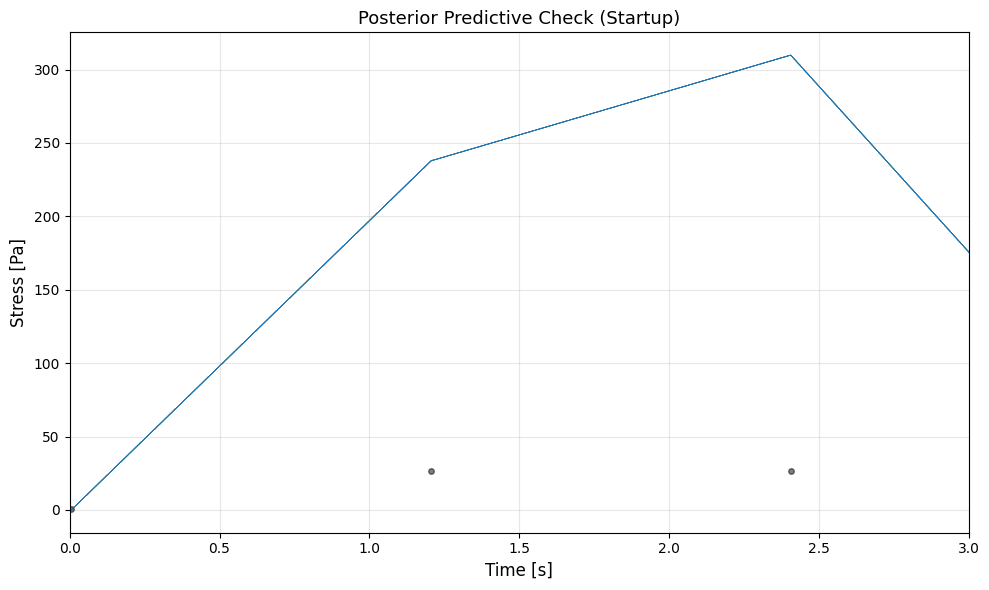

In [12]:
# Posterior predictive check
posterior = result.posterior_samples

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_data, stress_data, "ko", markersize=4, alpha=0.5, label="Data")

# Plot posterior samples
n_draws = min(50, len(list(posterior.values())[0]))
for i in range(n_draws):
    # Set model parameters from posterior sample
    for name in param_names:
        model.parameters.set_value(name, float(posterior[name][i]))
    pred_i = model.predict(t_data, test_mode="startup", gamma_dot=ref_rate)
    ax.plot(t_data, pred_i, "-", color="C0", alpha=0.1, lw=0.5)

ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("Posterior Predictive Check (Startup)", fontsize=13)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, min(t_data.max(), 3))
plt.tight_layout()
display(fig)
plt.close(fig)

In [13]:
# NLSQ vs Bayesian comparison
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G         283.2         283.2  [283.2, 283.2]
            eta         2e+06         2e+06  [2e+06, 2e+06]
              C         492.9         492.9  [492.8, 492.9]
      gamma_dyn         1.879         1.879  [1.879, 1.879]
              m         1.016         1.017  [1.016, 1.017]
       sigma_y0         9.985         9.985  [9.985, 9.985]
  delta_sigma_y         49.92         49.92  [49.92, 49.92]
       tau_thix         156.1         156.1  [156.1, 156.1]
          Gamma         3.506         3.506  [3.506, 3.506]
        eta_inf       0.09986       0.09986  [0.09986, 0.09986]
           mu_p         0.001         0.001  [0.001, 0.001]


## 6. Physical Interpretation

### Stress Overshoot Mechanism

The overshoot arises from two competing mechanisms:

1. **Initial elastic loading**: Stress increases as $\sigma \approx G \dot{\gamma} t$
2. **Plastic yielding + structure breakdown**: Once yielded, stress decreases as:
   - Backstress $\alpha$ develops (kinematic hardening)
   - Structure $\lambda$ decreases (thixotropy)

### Rate Dependence

- **Peak strain** ($\gamma_{peak}$): Approximately constant (strain-controlled overshoot)
- **Peak stress** ($\sigma_{peak}$): Increases with $\dot{\gamma}$ (rate sensitivity)
- **Peak time** ($t_{peak}$): Scales as $\gamma_{peak}/\dot{\gamma}$

## 7. Save Results

In [14]:
# Save results
save_ikh_results(model, result, "mikh", "startup", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mikh/startup/
  nlsq_params_startup.json: 11 parameters
  posterior_startup.json: 500 draws


## Key Takeaways

1. **Stress overshoot** in startup shear results from initial elastic loading followed by plastic flow and structure breakdown

2. **Kinematic hardening parameters** ($C$, $\gamma_{dyn}$) control the backstress evolution and overshoot shape

3. **Thixotropic parameters** ($\tau_{thix}$, $\Gamma$) determine how quickly structure breaks down during flow

4. **Rate dependence**: Higher $\dot{\gamma}$ leads to larger overshoot peak but shorter peak time

5. **Return mapping formulation** handles strain-driven protocols efficiently

### Next Steps

- **NB03**: Stress relaxation (synthetic from NB01 calibration)
- **NB04**: Creep response (real ML-IKH data)
- **NB05**: SAOS (synthetic from NB01 calibration)
- **NB06**: LAOS (real PNAS data)